# Imputing Age

In [1]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
testdata = pd.read_csv(data_dir + 'test.csv')

labels = data.Survived
data = data.drop('Survived', axis=1)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from functon_scripts.CustomEstimators import DropColumns, EmbarkedImputer
from functon_scripts.SpecialImputers import DiscreteVar
from sklearn.preprocessing import OneHotEncoder

cols = data.columns.drop(['Embarked', 'Age', 'Sex', 'Fare'])
fare_bins = [-1, 5, 10, 35, 100, 250, np.inf]
age_bins = [0, 18, 32, np.inf]
clean1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 5, 6]), cols),
    ('ohe', OneHotEncoder(), ['Sex']),
    ('dAge', DiscreteVar(bins=age_bins), ['Age']),
    ('dFare', DiscreteVar(bins=fare_bins), ['Fare']),
    ('EmbImp', EmbarkedImputer(), ['Embarked'])
])
# clean1 --

In [27]:
Pclass_ix = np.s_[:, 0]
SibSp_ix = np.s_[:, 1]
Parch_ix = np.s_[:, 2]
Sex_ix = np.s_[:, 3:5]
Age_ix = np.s_[:, 5]
Fare_ix = np.s_[:, 6]
Embarked_ix = np.s_[:, 7:10]

In [35]:
#train model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

clean_data = clean1.fit_transform(data)
clean_data = clean_data[~data.Age.isnull()]
y = clean_data[Age_ix].astype(int)
X = np.c_[clean_data[Pclass_ix], clean_data[Parch_ix],
            clean_data[SibSp_ix], clean_data[Sex_ix], clean_data[Fare_ix]]

param_grid = [
    {'n_estimators': np.arange(10, 30, step=2),
     'eta': np.arange(0.1, 0.2, 0.02),
     'reg_lambda': np.arange(0.1, 1, 0.2)
    },
]

xgb = XGBClassifier()

grids = GridSearchCV(xgb, param_grid, scoring="f1_macro", return_train_score=True, cv=5)
print(X.shape)
grids.fit(X, y)

joblib.dump(grids.best_estimator_, 'filename.pkl')
grids.best_params_

(714, 6)


{'eta': 0.14, 'n_estimators': 26, 'reg_lambda': 0.9000000000000001}

0.5714722164521726


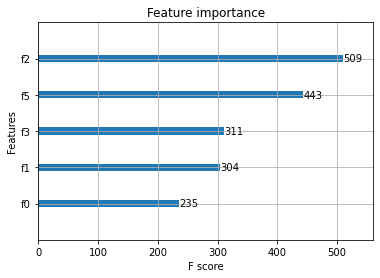

In [36]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)

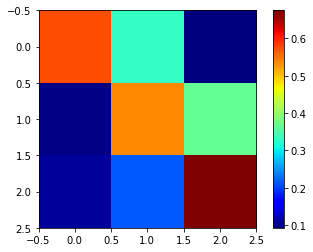

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from functon_scripts.SpecialImputers import ImputeAge

clean_testdata = clean1.fit_transform(testdata)
clean_testdata = clean_testdata[~testdata.Age.isnull()]
y = clean_testdata[Age_ix].astype(int)
X = np.c_[clean_testdata[Pclass_ix], clean_testdata[Parch_ix],
            clean_testdata[SibSp_ix], clean_testdata[Sex_ix], clean_testdata[Fare_ix]]

clean_testdata[Age_ix] = np.array([np.nan] * clean_testdata.shape[0])
y_hat = agimp.transform(clean_testdata)[Age_ix].astype(int)
y_hat = grids.best_estimator_.predict(X)
# y_hat = model.predict(X)

conf = confusion_matrix(y, y_hat)
D = np.diag(pd.value_counts(y).sort_index())
conf_mod = np.dot(np.linalg.inv(D), conf)
plt.imshow(conf_mod, cmap=plt.get_cmap('jet'))
plt.colorbar()

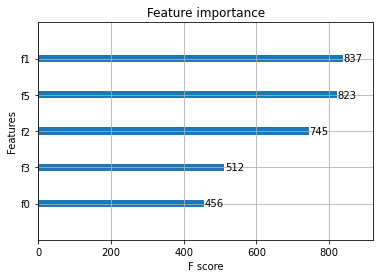

In [16]:
from xgboost import plot_importance

plot_importance(agimp.model.get_booster())

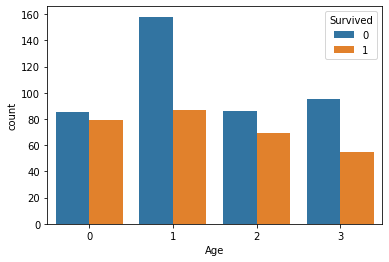

In [32]:
import seaborn as sns

_ = sns.countplot(data=clean_data, x='Age', hue=labels, order=np.arange(0,4))

In [7]:
model = joblib.load('filename.pkl')

In [8]:
model.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.21000000000000002,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.209999993,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=42, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)>

-151.08696331701339


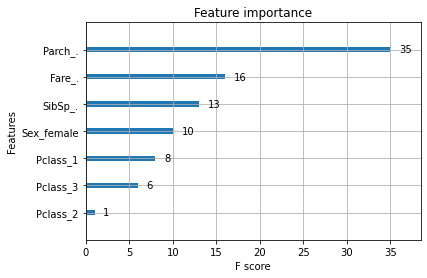

In [26]:
from xgboost import plot_importance

plot_importance(grids_xgb_age.best_estimator_)
print(grids_xgb_age.best_score_)

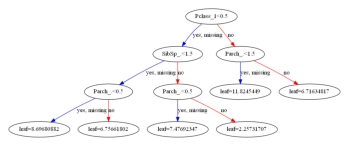

In [29]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_tree(grids_xgb_age.best_estimator_, figsize=(7, 5))